In [128]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

/tmp/ipykernel_2661/680206115.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [90]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print( gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array((np.nonzero(gt)[1], np.nonzero(gt)[0])).T # 非零坐标
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize) # 使用这种数据结构方便后续查找最近的点
    # query kdtree
    distances, locations = tree.query(pts, k=4) # 查找最近的4个点，为了后续进行高斯滤波，作为sigma

    print('generate density...') # 使用呢迭代的方式生成 density, 虽然pt2d整体上和gt一样都是images.shape生成的0，1矩阵，但是gt是共现的，pt2d只针对某个非零坐标出现非零值。因为是在循环里面
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print( 'done.')
    return density

In [91]:
#set the root to the Shanghai dataset you download
root = '/workspace/pap/data/attack_shanghai'

In [92]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [93]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [113]:
print (img_paths[0])
mat = io.loadmat(img_paths[0].replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
img= plt.imread(img_paths[0])
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["image_info"][0,0][0,0][0]
gt.shape


/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_391.jpg


(89, 2)

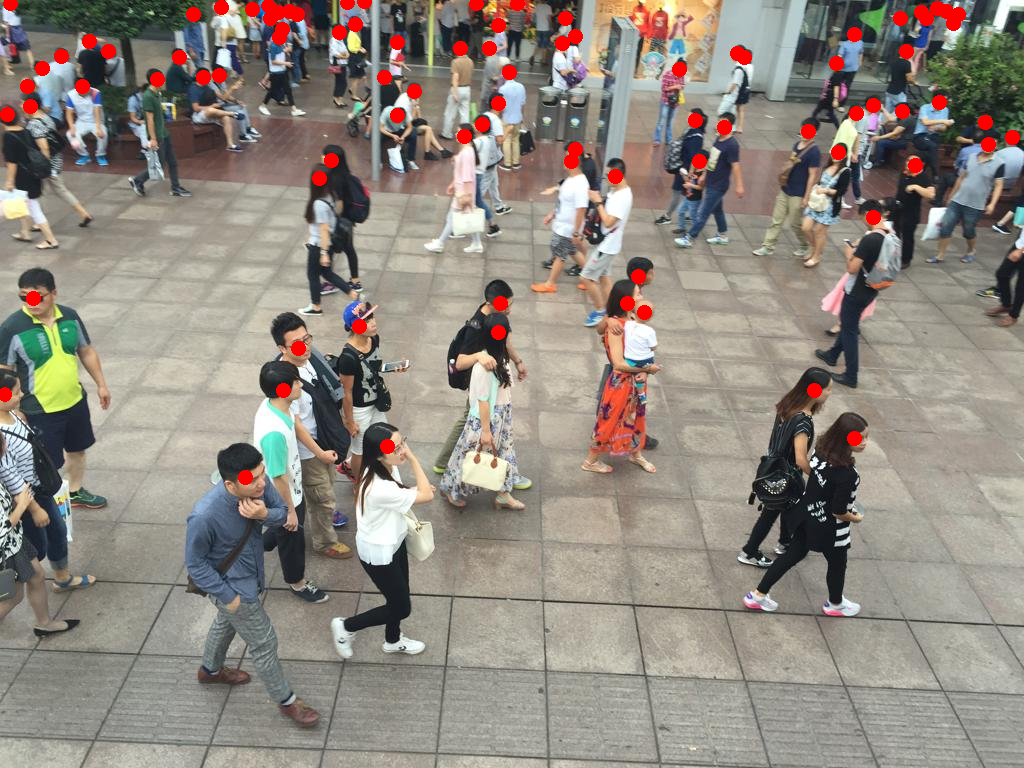

In [112]:

from PIL import ImageDraw
img = Image.open(img_paths[0])
draw = ImageDraw.Draw(img)

# Choose the color and size of the point
point_color = (255, 0, 0)  # Red color in RGB
point_size = 15  # Size of the point
for co in gt:
    # Draw a small circle at the point's location
    draw.ellipse((co[0] - point_size // 2, co[1] - point_size // 2, co[0] + point_size // 2, co[1] + point_size // 2), fill=point_color)
# for i in gt:
#     # Plot the point onto the image
#     draw.point(gt[0], fill=point_color)
img.show()

In [126]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1])) # iamges.shape with 0,1 
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    # import pdb;pdb.set_trace()
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k
    break


/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_391.jpg
(768, 1024)
generate density...


/tmp/ipykernel_2661/554454800.py:24: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


done.


In [127]:
gt

array([[ 245.53935122,  477.35501943],
       [ 283.2905033 ,  390.05548026],
       [ 298.62690883,  348.76515768],
       [ 359.97253095,  326.35041113],
       [ 387.1061715 ,  446.68220837],
       [ 498.00018072,  332.24902864],
       [ 500.35962772,  303.93566459],
       [  33.18912081,  298.03704708],
       [   4.87575675,  394.77437427],
       [ 627.76976597,  303.93566459],
       [ 644.285895  ,  312.1937291 ],
       [ 638.38727749,  276.80202404],
       [ 814.16607933,  390.05548026],
       [ 854.27667841,  438.42414385],
       [ 873.15225445,  217.81584892],
       [ 915.62230053,  165.90801482],
       [ 838.94027288,  152.93105629],
       [ 615.97253095,  176.52552634],
       [ 571.14303786,  161.18912081],
       [ 464.96792265,  136.41492726],
       [ 331.65916689,  160.00939731],
       [ 319.86193187,  178.88497334],
       [   7.23520376,  114.00018072],
       [  30.82967381,  106.9218397 ],
       [  82.73750791,   86.86654016],
       [ 157.06008855,   

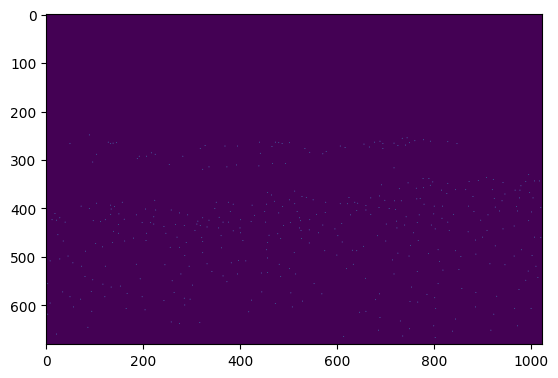

In [54]:
plt.imshow(k)

(681, 1024)
generate density...


/tmp/ipykernel_2661/554454800.py:24: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


done.


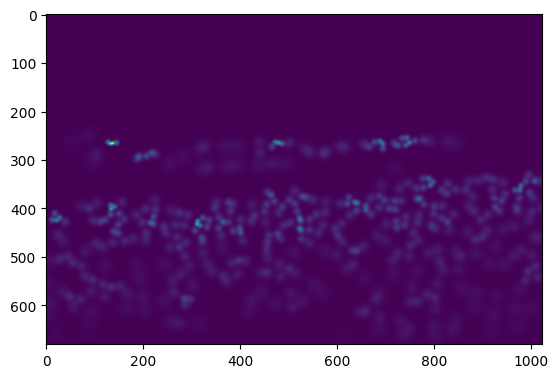

In [86]:
k = gaussian_filter_density(k)
plt.imshow(k)


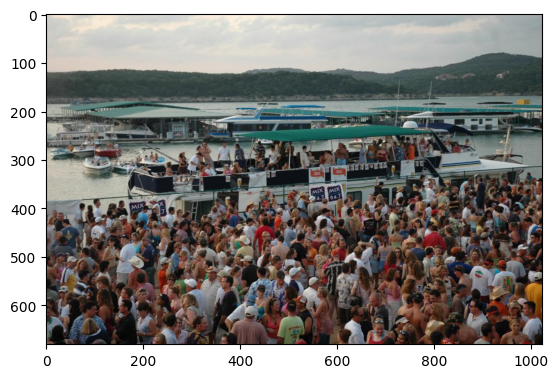

In [95]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

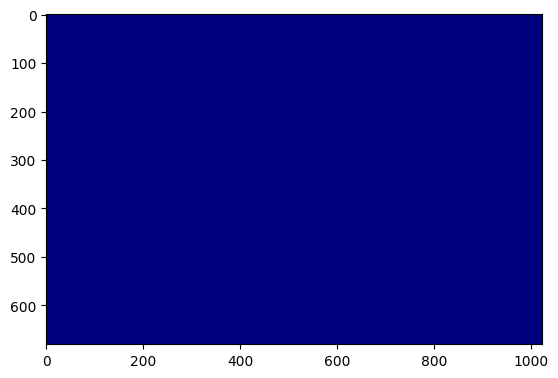

In [96]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [22]:
np.sum(groundtruth)# don't mind this slight variation

0.0

In [98]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [99]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [100]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_391.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_248.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_100.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_72.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_334.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_67.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_267.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_177.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_63.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_89.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_185.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_data/images/IMG_138.jpg
/workspace/pap/data/attack_shanghai/part_B_final/train_d

['/workspace/pap/data/comp/test_data/gtjson/000007.json', '/workspace/pap/data/comp/test_data/gtjson/000009.json', '/workspace/pap/data/comp/test_data/gtjson/000004.json', '/workspace/pap/data/comp/test_data/gtjson/000017.json', '/workspace/pap/data/comp/test_data/gtjson/000015.json', '/workspace/pap/data/comp/test_data/gtjson/000024.json', '/workspace/pap/data/comp/test_data/gtjson/000003.json', '/workspace/pap/data/comp/test_data/gtjson/000025.json', '/workspace/pap/data/comp/test_data/gtjson/000022.json', '/workspace/pap/data/comp/test_data/gtjson/000010.json', '/workspace/pap/data/comp/test_data/gtjson/000013.json', '/workspace/pap/data/comp/test_data/gtjson/000021.json', '/workspace/pap/data/comp/test_data/gtjson/000001.json', '/workspace/pap/data/comp/test_data/gtjson/000000.json', '/workspace/pap/data/comp/test_data/gtjson/000018.json', '/workspace/pap/data/comp/test_data/gtjson/000005.json', '/workspace/pap/data/comp/test_data/gtjson/000006.json', '/workspace/pap/data/comp/test

In [139]:
def json2npy():
    import numpy as np
    import json

    path = "/workspace/pap/data/comp/test_data/gtjson"
    json_paths = []
    for img_path in glob.glob(os.path.join(path, '*.json')):
        json_paths.append(img_path)
    print(json_paths)


    for file_path in json_paths:
        print(file_path)
        # Open the JSON file and read its contents into a variable
        with open(file_path, 'r') as file:
            data = json.load(file)

        points_list = []

        # Iterate over each shape and extract the points
        for shape in data["shapes"]:
            points = shape.get("points", [])
            points_list.append(points)

        # Convert the list of points to a NumPy array
        points_array = np.array(points_list).reshape(-1,2)
        # print(points_array.shape)
        np.save(file_path.replace("gtjson", "ground_truth").replace(".json", ".npy"), points_array)


/workspace/pap/data/comp/test_data/gtjson/000007.json
/workspace/pap/data/comp/test_data/gtjson/000009.json
/workspace/pap/data/comp/test_data/gtjson/000004.json
/workspace/pap/data/comp/test_data/gtjson/000017.json
/workspace/pap/data/comp/test_data/gtjson/000015.json
/workspace/pap/data/comp/test_data/gtjson/000024.json
/workspace/pap/data/comp/test_data/gtjson/000003.json
/workspace/pap/data/comp/test_data/gtjson/000025.json
/workspace/pap/data/comp/test_data/gtjson/000022.json
/workspace/pap/data/comp/test_data/gtjson/000010.json
/workspace/pap/data/comp/test_data/gtjson/000013.json
/workspace/pap/data/comp/test_data/gtjson/000021.json
/workspace/pap/data/comp/test_data/gtjson/000001.json
/workspace/pap/data/comp/test_data/gtjson/000000.json
/workspace/pap/data/comp/test_data/gtjson/000018.json
/workspace/pap/data/comp/test_data/gtjson/000005.json
/workspace/pap/data/comp/test_data/gtjson/000006.json
/workspace/pap/data/comp/test_data/gtjson/000002.json
/workspace/pap/data/comp/tes

In [142]:
from PIL import ImageDraw
from PIL import Image

root = "/workspace/pap/data/comp/test_data/images"
img_paths = []
for img_path in glob.glob(os.path.join(root, '*.jpg')):
    img_paths.append(img_path)

# Choose the color and size of the point
point_color = (255, 0, 0)  # Red color in RGB

img = Image.open(img_paths[0])




AttributeError: shape

In [145]:
np.array(img)



array([[[166, 154, 140],
        [170, 158, 142],
        [172, 159, 142],
        ...,
        [177, 161, 146],
        [177, 161, 146],
        [178, 162, 147]],

       [[157, 145, 131],
        [159, 147, 131],
        [158, 145, 128],
        ...,
        [175, 159, 144],
        [176, 160, 145],
        [176, 160, 145]],

       [[157, 145, 131],
        [156, 144, 128],
        [153, 140, 123],
        ...,
        [175, 159, 144],
        [176, 160, 145],
        [176, 160, 145]],

       ...,

       [[120, 110, 100],
        [120, 110, 100],
        [120, 110, 100],
        ...,
        [121, 111, 101],
        [121, 111, 101],
        [121, 111, 101]],

       [[120, 110, 100],
        [120, 110, 100],
        [120, 110, 100],
        ...,
        [120, 110, 100],
        [120, 110, 100],
        [120, 110, 100]],

       [[120, 110, 100],
        [120, 110, 100],
        [120, 110, 100],
        ...,
        [119, 109,  99],
        [120, 110, 100],
        [119, 109,  99]]

In [148]:
dummy = np.zeros_like(img)

In [160]:
dummy = dummy + 255
dummy

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

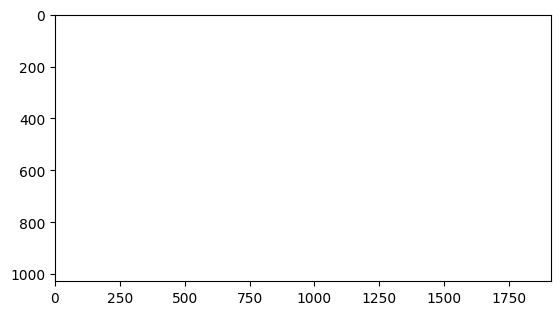

In [161]:
plt.imshow(dummy)

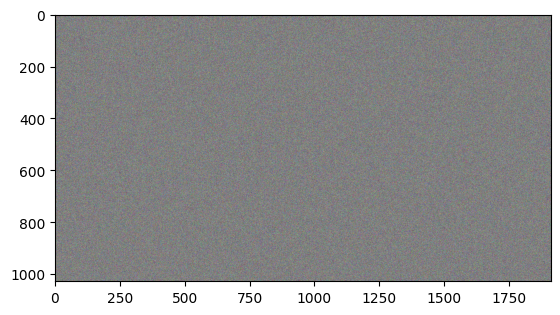

In [176]:
noise = np.random.randint(64, 192, size=np.array(img).shape, dtype=np.uint8)
plt.imshow(noise)

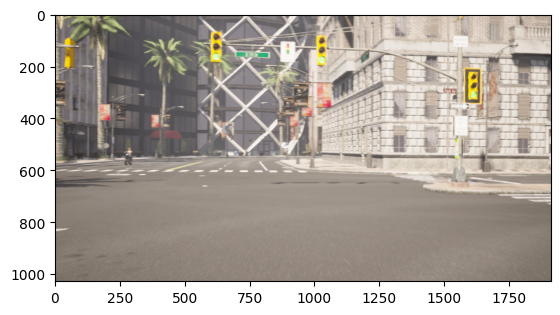

In [177]:
plt.imshow(img)

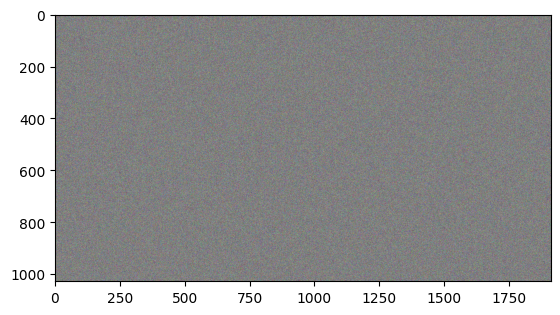

In [178]:
dummy = noise
plt.imshow(dummy)

In [179]:
save_path = "/workspace/pap/results/comp/"
for p in img_paths:
    newp = os.path.join(save_path, os.path.basename(p))
    print(newp)
    Image.fromarray(dummy).save(newp)

/workspace/pap/results/comp/000111.jpg
/workspace/pap/results/comp/000256.jpg
/workspace/pap/results/comp/000192.jpg
/workspace/pap/results/comp/000198.jpg
/workspace/pap/results/comp/000382.jpg
/workspace/pap/results/comp/000230.jpg
/workspace/pap/results/comp/000077.jpg
/workspace/pap/results/comp/000264.jpg
/workspace/pap/results/comp/000307.jpg
/workspace/pap/results/comp/000289.jpg
/workspace/pap/results/comp/000416.jpg
/workspace/pap/results/comp/000221.jpg
/workspace/pap/results/comp/000426.jpg
/workspace/pap/results/comp/000030.jpg
/workspace/pap/results/comp/000276.jpg
/workspace/pap/results/comp/000373.jpg
/workspace/pap/results/comp/000374.jpg
/workspace/pap/results/comp/000204.jpg
/workspace/pap/results/comp/000036.jpg
/workspace/pap/results/comp/000267.jpg
/workspace/pap/results/comp/000003.jpg
/workspace/pap/results/comp/000253.jpg
/workspace/pap/results/comp/000216.jpg
/workspace/pap/results/comp/000401.jpg
/workspace/pap/results/comp/000058.jpg
/workspace/pap/results/co